# Import The Dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.layers import Activation
from keras.models import Model
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, LSTM
# from keras.callbacks import ModelCheckpoint
from transformers import TFBertForSequenceClassification, BertTokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

from collections import Counter


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Prepare data

In [3]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count training samples: 2952
Count testing samples: 739


In [4]:
train_df = pd.DataFrame({"term_str": x_train, "steps_lo": y_train_})
test_df = pd.DataFrame({"term_str": x_test, "steps_lo": y_test_})

In [5]:
# The path of the model checkpoint we want to use

model_dir = './fine_models/input/huggingface-bert/bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_dir)

In [6]:
tokenizer(list(train_df['term_str'][0:3]), truncation=True, padding='max_length', max_length=512)

{'input_ids': [[101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 137, 193, 119, 113, 137, 193, 119, 193, 114, 114, 114, 113, 113, 137, 193, 119, 113, 137, 193, 119, 113, 113, 193, 113, 137, 193, 119, 193, 114, 114, 193, 114, 114, 114, 113, 137, 193, 119, 193, 114, 114, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
term_str = train_df['term_str'][0]
full_srt = ""
for x_ in term_str:
    full_srt += x_
    tokets_ = tokenizer(full_srt)
    print(full_srt, tokets_['input_ids'])

( [101, 113, 102]
(( [101, 113, 113, 102]
((( [101, 113, 113, 113, 102]
(((@ [101, 113, 113, 113, 137, 102]
(((@x [101, 113, 113, 113, 137, 193, 102]
(((@x. [101, 113, 113, 113, 137, 193, 119, 102]
(((@x.  [101, 113, 113, 113, 137, 193, 119, 102]
(((@x. x [101, 113, 113, 113, 137, 193, 119, 193, 102]
(((@x. x) [101, 113, 113, 113, 137, 193, 119, 193, 114, 102]
(((@x. x)  [101, 113, 113, 113, 137, 193, 119, 193, 114, 102]
(((@x. x) ( [101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 102]
(((@x. x) (@ [101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 137, 102]
(((@x. x) (@x [101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 137, 193, 102]
(((@x. x) (@x. [101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 137, 193, 119, 102]
(((@x. x) (@x.  [101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 137, 193, 119, 102]
(((@x. x) (@x. ( [101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 137, 193, 119, 113, 102]
(((@x. x) (@x. (@ [101, 113, 113, 113, 137, 193, 119, 193, 114, 113, 137, 193, 119, 113

In [7]:
label_encoder = {key_: [0.0] * 31 for key_ in range(31)}
for key_ in label_encoder.keys():
    label_encoder[key_][key_] = 1.0


def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(list(example["term_str"]), truncation=True, padding=True, max_length=512, return_tensors="tf")
    labels = tf.convert_to_tensor([label_encoder[key_] for key_ in example["steps_lo"]])
    return tokenized_texts, labels

In [8]:
tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [9]:
tokenized_train_data[0]["input_ids"]

<tf.Tensor: shape=(2952, 512), dtype=int32, numpy=
array([[101, 113, 113, ...,   0,   0,   0],
       [101, 113, 113, ...,   0,   0,   0],
       [101, 113, 137, ...,   0,   0,   0],
       ...,
       [101, 113, 113, ...,   0,   0,   0],
       [101, 113, 113, ...,   0,   0,   0],
       [101, 113, 113, ...,   0,   0,   0]])>

In [10]:
batch_size = 3

train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

In [11]:
model = TFBertForSequenceClassification.from_pretrained(model_dir, num_labels=31)
model.get_layer("bert").trainable = False
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ./fine_models/input/huggingface-bert/bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  23839     
                                                                 
Total params: 108,334,111
Trainable params: 23,839
Non-trainable params: 108,310,272
_________________________________________________________________


In [12]:
# Define the optimizer and loss function
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [13]:
# Train the model
epochs = 10
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
984/984 [==============================] - 193s 182ms/step - loss: 8.3781 - accuracy: 0.0972 - val_loss: 10.2947 - val_accuracy: 0.1042
Epoch 2/10
984/984 [==============================] - 210s 213ms/step - loss: 8.3994 - accuracy: 0.1003 - val_loss: 10.3469 - val_accuracy: 0.1055
Epoch 3/10
984/984 [==============================] - 202s 205ms/step - loss: 8.0073 - accuracy: 0.0742 - val_loss: 5.9836 - val_accuracy: 0.0974
Epoch 4/10
984/984 [==============================] - 204s 207ms/step - loss: 7.9066 - accuracy: 0.1081 - val_loss: 10.3129 - val_accuracy: 0.0812
Epoch 5/10
984/984 [==============================] - 190s 194ms/step - loss: 8.2713 - accuracy: 0.0837 - val_loss: 10.2953 - val_accuracy: 0.0880
Epoch 6/10
984/984 [==============================] - 142s 144ms/step - loss: 8.9687 - accuracy: 0.0874 - val_loss: 5.8026 - val_accuracy: 0.0880
Epoch 7/10
984/984 [==============================] - 204s 208ms/step - loss: 9.7647 - accuracy: 0.0864 - val_loss: 10.2

In [14]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

247/247 [==============================] - 38s 154ms/step


In [15]:
train_preds.logits

array([[ 28.321495,  28.88825 ,  30.959143, ..., -16.43055 , -14.756531,
        -15.156447],
       [ 27.267366,  27.310863,  29.226004, ..., -15.105263, -13.093788,
        -13.809407],
       [ 27.366375,  27.590643,  29.566595, ..., -15.476986, -13.646675,
        -14.216265],
       ...,
       [ 27.43885 ,  27.314089,  29.22293 , ..., -14.946133, -12.841336,
        -13.671365],
       [ 27.69843 ,  28.140759,  30.112478, ..., -15.939112, -14.169891,
        -14.640773],
       [ 27.922106,  28.436777,  30.453096, ..., -16.120316, -14.398011,
        -14.82848 ]], dtype=float32)

In [16]:
train_preds_nums = [np.argmax(x_) for x_ in train_preds.logits]
test_preds_nums = [np.argmax(x_) for x_ in test_preds.logits]

In [17]:
train_true_nums = y_train_
test_true_nums = y_test_

In [18]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

Train accuracy: 0.08672086720867209


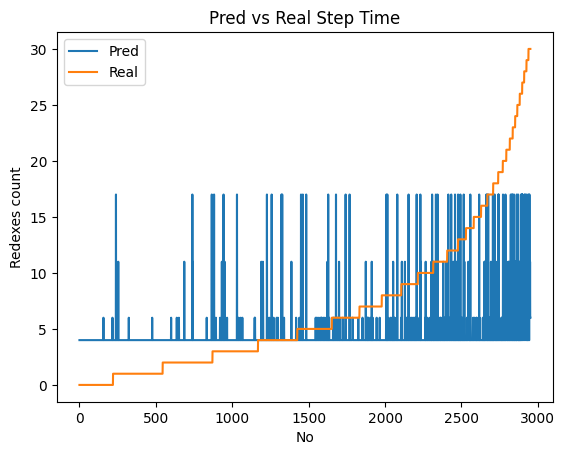

In [19]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)

Test accuracy: 0.08930987821380243


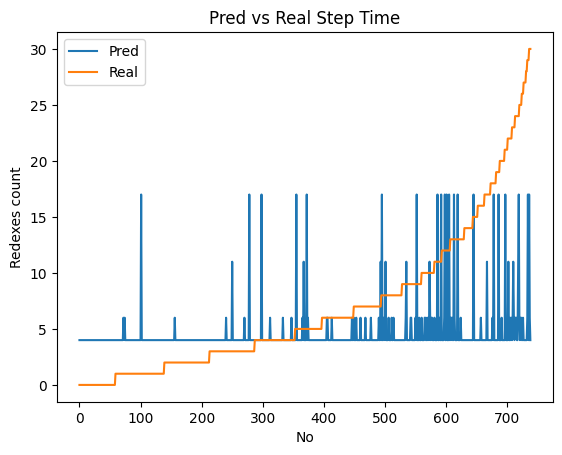

In [20]:
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

# Do additional metrics testing

# Mean Squared Error

In [21]:
train_preds_nums = np.array(train_preds_nums)
test_preds_nums = np.array(test_preds_nums)

train_true_nums = np.array(train_true_nums)
test_true_nums = np.array(test_true_nums)

In [22]:
mse_train = mean_squared_error(train_true_nums, train_preds_nums)
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(test_true_nums, test_preds_nums)
print("Test {Mean Squared Error}:", mse_test)

Train {Mean Squared Error}: 43.386856368563684
Test {Mean Squared Error}: 45.70500676589987


## Mean Absolute Error

In [23]:
mae_train = mean_absolute_error(train_true_nums, train_preds_nums)
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(test_true_nums, test_preds_nums)
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 4.479674796747967
Test {Mean Absolute Error}: 4.571041948579161


## Mean Absolute Percentage Error

In [24]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(train_true_nums, train_preds_nums)
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(test_true_nums, test_preds_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Absolute Percentage Error}: 299535.3316778912
Test {Mean Absolute Percentage Error}: 319427.56206626893


## Percentage of Explained Variance (PEV)

In [25]:
# Calculate Variance of the target variable
variance_y_train = np.var(train_true_nums)
variance_y_test = np.var(test_true_nums)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Test {Percentage of Explained Variance}:", pev_test)

Train {Percentage of Explained Variance}: -4.149142211110579
Test {Percentage of Explained Variance}: -7.257908018084325


## Mean Bias Deviation

In [26]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(train_true_nums, train_preds_nums)
print("Train {Mean Bias Deviation}:", mbd_train)

mdb_test = mean_bias_deviation(test_true_nums, test_preds_nums)
print("Test {Mean Bias Deviation}:", mdb_test)

Train {Mean Bias Deviation}: 299484.1000601812
Test {Mean Bias Deviation}: 319376.8108658918


## Coefficient of Correlation (Pearson's r)

In [27]:
coc_test = np.corrcoef(train_preds_nums, train_true_nums)[0, 1]
coc_train = np.corrcoef(test_preds_nums, test_true_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

Train {Mean Bias Deviation}: 0.24358822808447828
Test {Mean Bias Deviation}: 0.28802025865369746


# ERROR STD

In [28]:
train_error = train_true_nums - train_preds_nums
test_error = test_true_nums - test_preds_nums
print("Train Error STD:", np.abs(train_error).std())
print("Test Error STD:", np.abs(test_error).std())

Train Error STD: 4.829013365475886
Test Error STD: 4.981022211376846


In [29]:
def advanced_point_drawer(y_real, y_pred, title="Train dataset"):
    counter = Counter([(x_, y_) for x_, y_ in zip(y_real, y_pred)])
    coords_count = dict(counter)

    plt.figure(figsize=(12, 12))

    coords_count_rev = dict()
    for key_, val_ in coords_count.items():
        if val_ not in coords_count_rev:
            coords_count_rev[val_] = []
        coords_count_rev[val_].append(key_)

    tcoords_count_rev = dict()
    for key_ in sorted(coords_count_rev.keys()):
        tcoords_count_rev[key_] = coords_count_rev[key_]

    coords_count_rev = tcoords_count_rev

    for key_, val_ in coords_count_rev.items():
        coords_data = np.array(val_)
        plt.scatter(coords_data[:, 0], coords_data[:, 1], s=key_ ** 1 + 5, c='tab:blue', label=f"\n{key_}\n")

    plt.plot([0, 31], [0, 31], c="gray", linestyle="--")
    plt.axis("equal")
    plt.xlabel("Real", fontsize=18)
    plt.ylabel("Predict", fontsize=18)
    plt.title(title, fontsize=20)
    plt.legend(prop={'size': 10})
    plt.show()

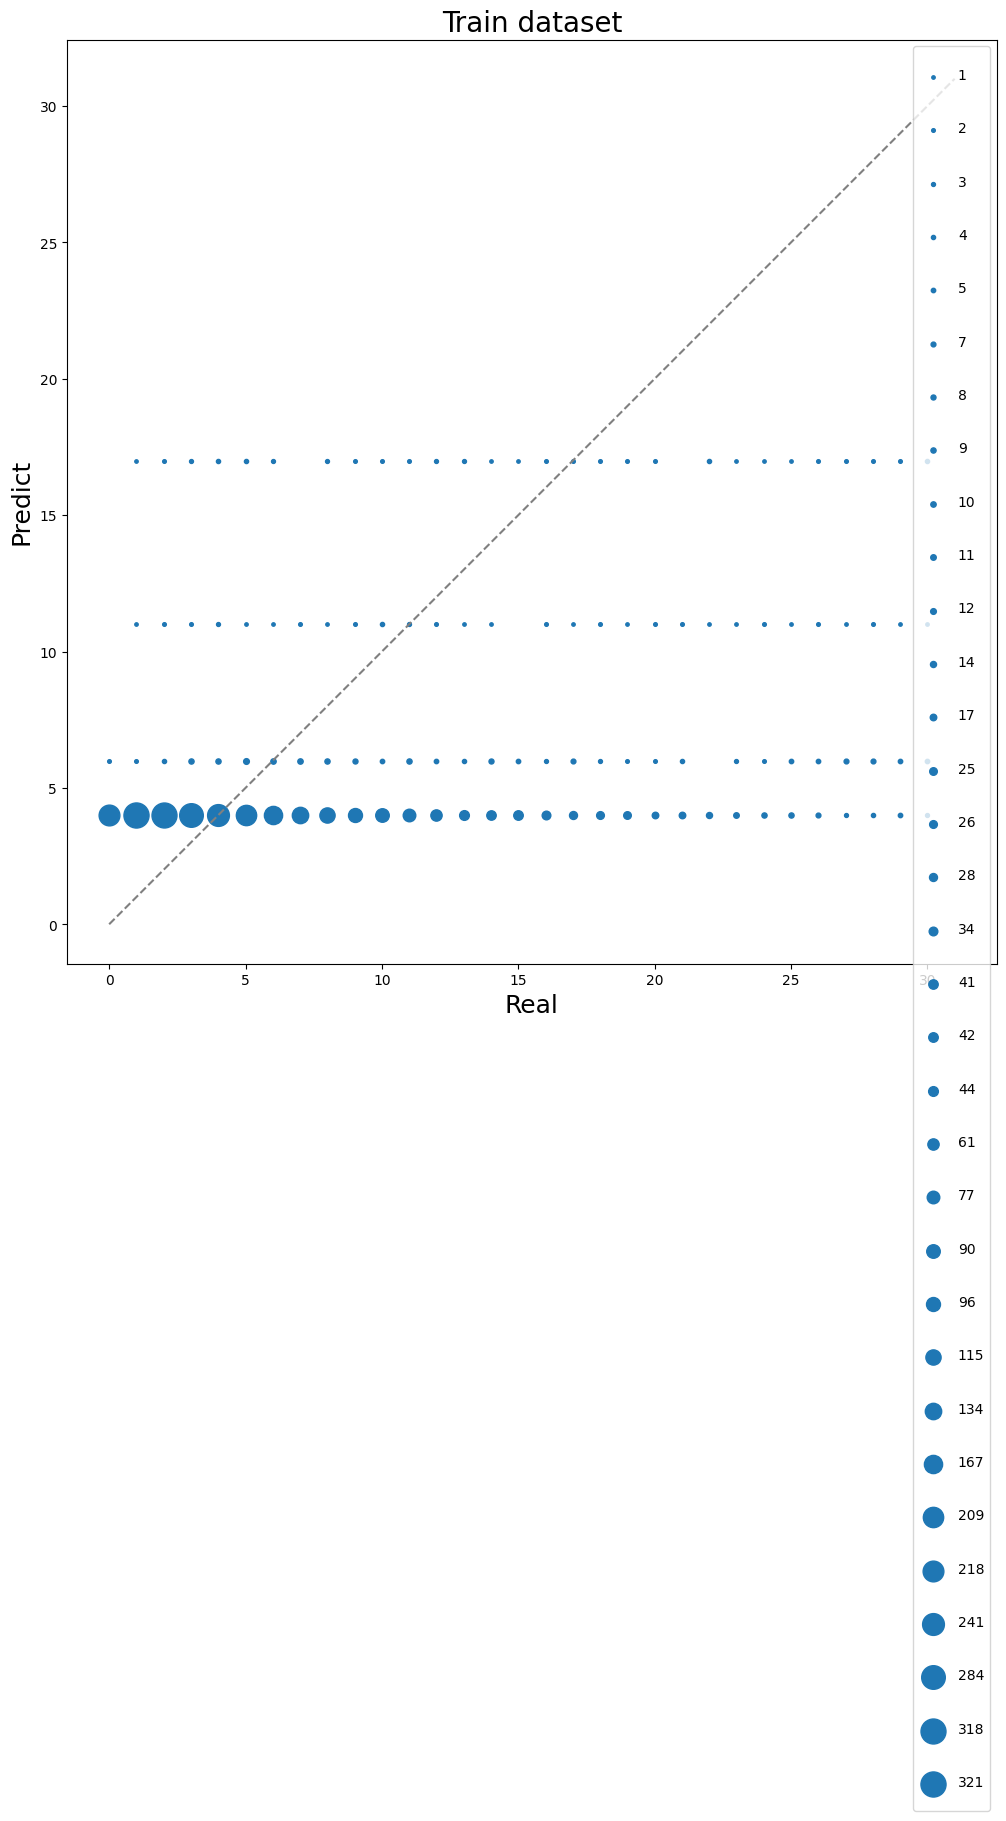

In [30]:
advanced_point_drawer(train_true_nums, train_preds_nums)

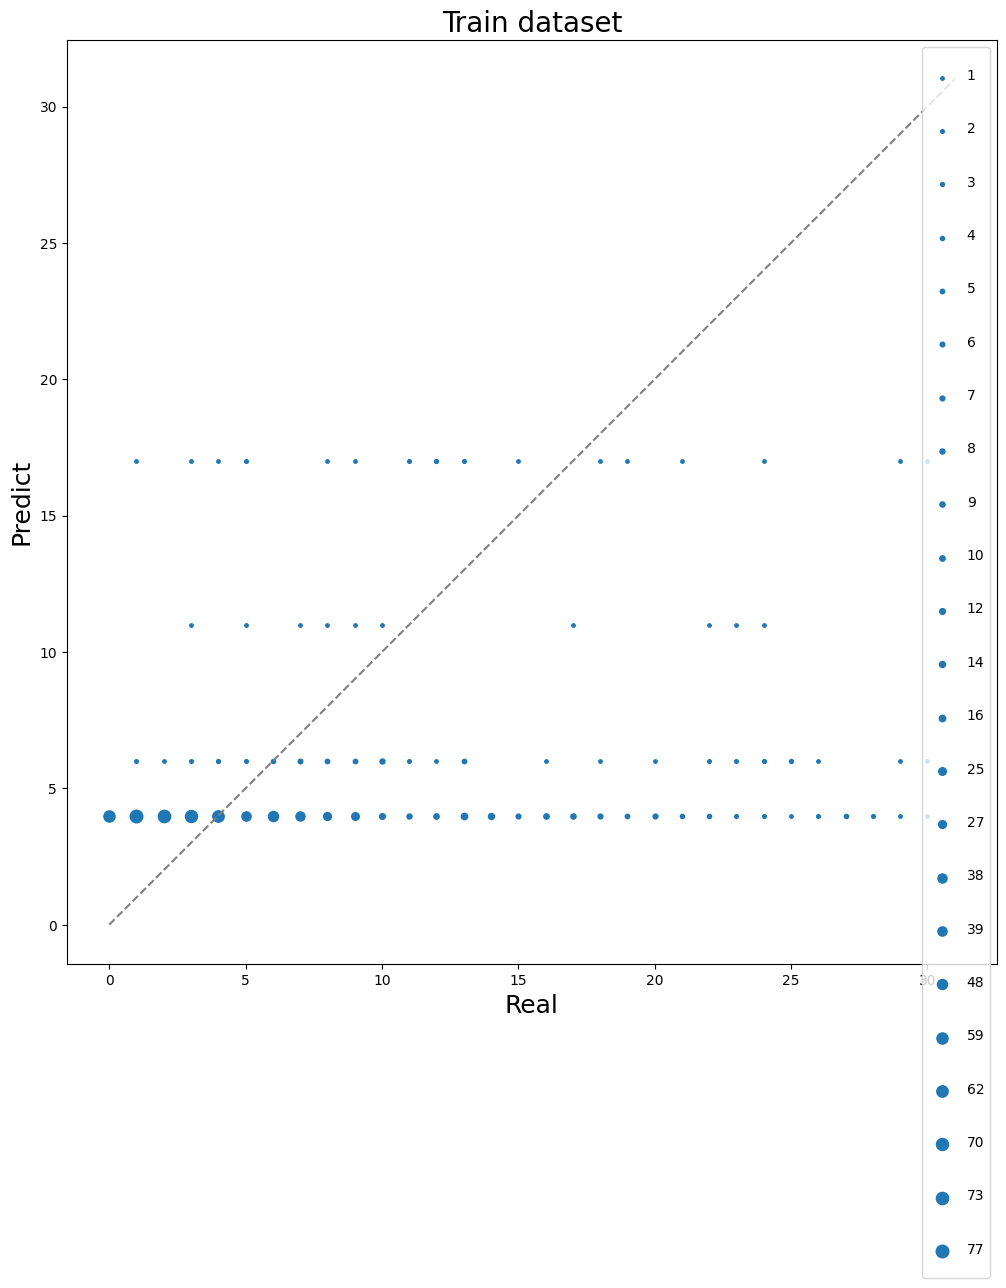

In [31]:
advanced_point_drawer(test_true_nums, test_preds_nums)